In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:

def calculate_metrics(y_true, y_pred, training_time):
    """평가 지표 계산 함수"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Training_Time': training_time
    }


def train_evaluate_cat(data, target_col='avgPrice', time_series=True):
   X = data.drop(['date', 'item', target_col], axis=1)
   y = data[target_col]

   cat_params = {
       'iterations': [500],
       'depth': [6, 8],
       'learning_rate': [0.01, 0.05],
       'l2_leaf_reg': [3, 5],
       'subsample': [0.8, 0.9],
       'random_strength': [1, 3],
       'random_seed': [1030],
       'thread_count': [-1]
   }

   if time_series:
       train_size = len(X)//2
       test_size = len(X)//10
       cv = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)
   else:
       cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

   cat = CatBoostRegressor(random_seed=1030, thread_count=-1, verbose=False)
   grid_search = GridSearchCV(
       cat, cat_params,
       cv=cv,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       verbose=1
   )

   grid_search.fit(X, y)

   print("\n** Model Performance **")
   print(f"Best RMSE: {-grid_search.best_score_:.4f}")
   print("\nBest Parameters:")
   for param, value in grid_search.best_params_.items():
       print(f"{param}: {value}")

   y_pred = grid_search.predict(X)
   plt.figure(figsize=(15, 7))
   plt.plot(data['date'], y, label='Actual', color='blue')
   plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
   plt.title('Actual vs Predicted Price')
   plt.xlabel('Date')
   plt.ylabel('Price')
   plt.legend()
   plt.grid(True)
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

   metrics = calculate_metrics(y, y_pred, 0)
   print("\nFinal Metrics:")
   for k, v in metrics.items():
       if k != 'Training_Time':
           print(f"{k}: {v:.4f}")

   return grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits

** Model Performance **
Best RMSE: 1213.5177

Best Parameters:
depth: 6
iterations: 500
l2_leaf_reg: 5
learning_rate: 0.05
random_seed: 1030
random_strength: 3
subsample: 0.9
thread_count: -1


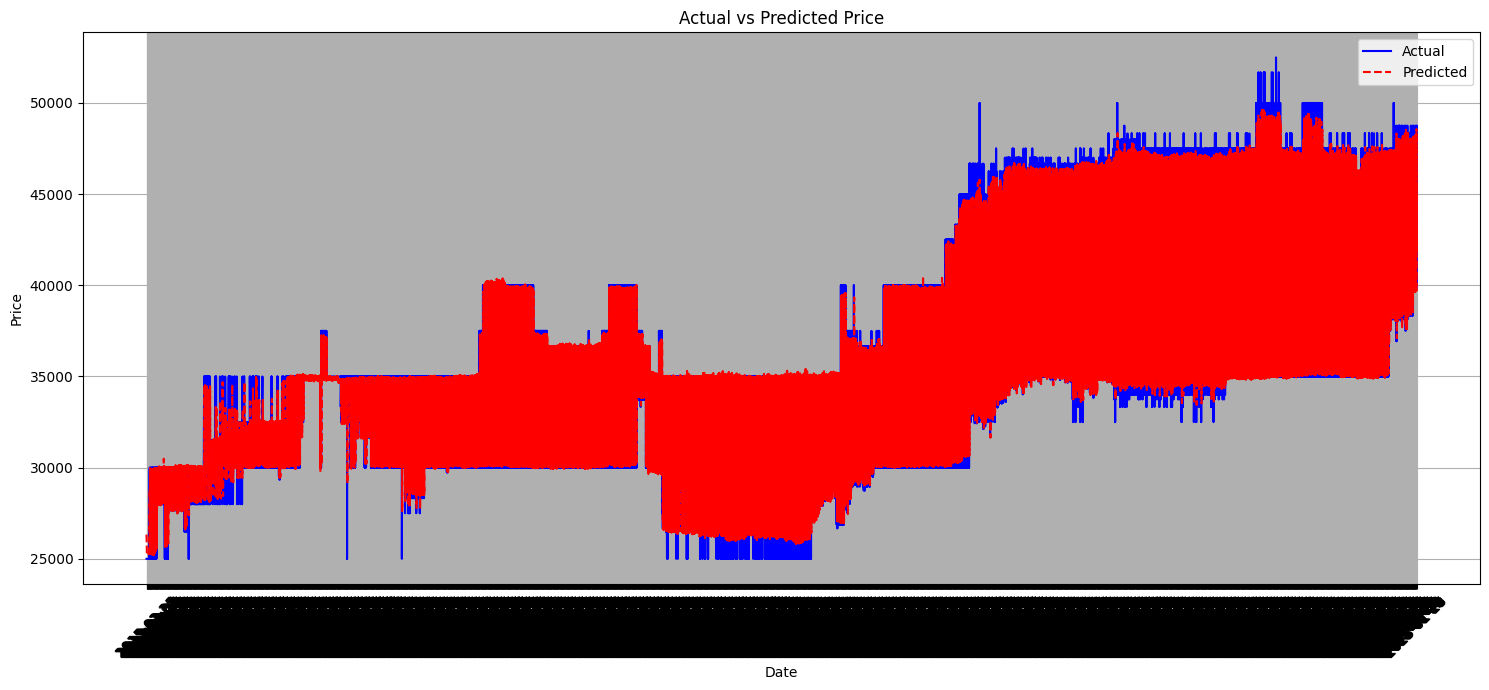


Final Metrics:
MAE: 330.3777
MSE: 494861.7440
RMSE: 703.4641
R2: 0.9796
RMSLE: 0.0195
MAPE: 0.9211


In [5]:
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_oneHot.csv')
train_evaluate_cat(data, target_col='avgPrice', time_series=True)